# Cell 1: Imports and Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("[DEBUG] Libraries loaded.")

[DEBUG] Libraries loaded.


# Cell 2: Global Configuration

In [2]:
print("[DEBUG] Setting global configuration...")
# --- Main Paths ---
BASE_DIR = Path("./PS2-SIH25").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
ARTIFACT_DIR = Path("artifacts/final_models")

SITE_IDS = [f"site_{i}" for i in range(1, 8)]

# --- Data & Model Parameters ---
SITE_TO_EVALUATE = "site_1"  # Evaluating on one site to conserve RAM
TARGET_COLUMNS = ["O3_target", "NO2_target"]
FORECAST_COLUMNS = ["O3_forecast", "NO2_forecast", "T_forecast", "q_forecast", "u_forecast", "v_forecast", "w_forecast"]
SATELLITE_COLUMNS = ["NO2_satellite", "HCHO_satellite", "ratio_satellite"]
TIME_COLUMNS = ["year", "month", "day", "hour"]
RANDOM_SEED = 42
TREE_ROLLING_WINDOWS = [6, 24]


# --- Environment Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESULTS = {}
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"[INFO] Evaluating on a sample site: {SITE_TO_EVALUATE}")
print(f"[DEBUG] Artifacts directory: {ARTIFACT_DIR}")
print(f"[DEBUG] Using device: {DEVICE}")

[DEBUG] Setting global configuration...
[INFO] Evaluating on a sample site: site_1
[DEBUG] Artifacts directory: artifacts/final_models
[DEBUG] Using device: cuda


# Cell 2: Global Configuration

In [3]:
print("[DEBUG] Defining all necessary helper functions and classes...")

# --- Core Data Utilities ---
def ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
    return df

def load_site_dataframe(site_id: str) -> pd.DataFrame:
    path = DATA_DIR / f"{site_id}_train_data.csv"
    df = pd.read_csv(path)
    df["site_id"] = site_id
    df = ensure_timestamp(df)
    df = df.sort_values("timestamp").reset_index(drop=True)
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate().ffill().bfill()
    return df

# def evaluate_predictions(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_true, y_pred)
#     return {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)}

def chronological_split(df: pd.DataFrame, split_ratio: float = 0.8):
    unique_ts = np.sort(df["timestamp"].unique())
    cutoff_index = int(len(unique_ts) * split_ratio)
    cutoff_index = max(1, min(cutoff_index, len(unique_ts) - 1))
    cutoff = unique_ts[cutoff_index]
    train_mask = df["timestamp"] <= cutoff
    train_df = df.loc[train_mask].reset_index(drop=True)
    val_df = df.loc[~train_mask].reset_index(drop=True)
    print(f"[DEBUG] Chronological split at {cutoff} -> train {len(train_df)}, val {len(val_df)}")
    return train_df, val_df

# --- Feature Engineering Functions ---
def add_time_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour_sin"] = np.sin(2 * math.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * math.pi * df["hour"] / 24)
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["dow_sin"] = np.sin(2 * math.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * math.pi * df["dayofweek"] / 7)
    return df

def add_lag_features(df: pd.DataFrame, columns: list[str], window: int) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        for lag in range(1, window + 1):
            df[f"{col}_lag_{lag}"] = df.groupby("site_id")[col].shift(lag)
    return df

def add_rolling_features(df: pd.DataFrame, columns: list[str], windows: list[int]) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        if col not in df.columns: continue
        for window in windows:
            feature_name = f"{col}_roll_mean_{window}"
            df[feature_name] = df.groupby("site_id")[col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    return df

# --- LSTM Specific Functions & Classes ---
def build_feature_matrix(df: pd.DataFrame, add_site_one_hot: bool = True):
    base = df.copy()
    base = add_time_signals(base)
    if add_site_one_hot:
        site_dummies = pd.get_dummies(base["site_id"], prefix="site")
        for site_id in SITE_IDS:
            col_name = f"site_{site_id}"
            if col_name not in site_dummies.columns:
                site_dummies[col_name] = 0
        base = pd.concat([base, site_dummies], axis=1)
    feature_cols = [col for col in base.columns if col not in TARGET_COLUMNS + ["timestamp", "site_id"]]
    return base, feature_cols

def generate_sequences(df: pd.DataFrame, feature_cols: list[str], window: int, horizon: int) -> list[dict]:
    sequences = []
    for site_id, site_df in df.groupby("site_id"):
        site_df = site_df.reset_index(drop=True)
        feat_vals = site_df[feature_cols].to_numpy(dtype=np.float32)
        targ_vals = site_df[TARGET_COLUMNS].to_numpy(dtype=np.float32)
        for idx in range(window, len(site_df) - horizon):
            sequences.append({"x": feat_vals[idx - window: idx], "y": targ_vals[idx: idx + horizon]})
    return sequences

def project_sequences_to_target(sequences, target_col):
    idx = TARGET_COLUMNS.index(target_col)
    return [{**seq, 'y': seq['y'][:, [idx]]} for seq in sequences]

def split_sequences_lstm(sequences: list, train_ratio=0.7, val_ratio=0.15):
    total = len(sequences)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    return sequences[:train_end], sequences[train_end:val_end], sequences[val_end:]

def apply_scalers(sequences: list[dict], feature_scaler: StandardScaler, target_scaler: StandardScaler):
    return [{**seq, "x": feature_scaler.transform(seq["x"]), "y": target_scaler.transform(seq["y"])} for seq in sequences]

def inverse_transform_predictions(preds: np.ndarray, scaler: StandardScaler) -> np.ndarray:
    flat = preds.reshape(-1, preds.shape[-1])
    restored = scaler.inverse_transform(flat)
    return restored.reshape(preds.shape)

class SequenceDataset(Dataset):
    def __init__(self, sequences: list[dict]):
        self.features = torch.tensor(np.stack([s["x"] for s in sequences]), dtype=torch.float32)
        self.targets = torch.tensor(np.stack([s["y"] for s in sequences]), dtype=torch.float32)
    def __len__(self): return self.features.shape[0]
    def __getitem__(self, idx: int): return self.features[idx], self.targets[idx]

class TemporalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, horizon, target_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.horizon, self.target_dim = horizon, target_dim
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, horizon * target_dim)
    def forward(self, x):
        output, _ = self.lstm(x)
        preds = self.fc(output[:, -1, :])
        return preds.view(-1, self.horizon, self.target_dim)

print("[DEBUG] Helper functions and classes defined.")

[DEBUG] Defining all necessary helper functions and classes...
[DEBUG] Helper functions and classes defined.


# Cell 3: Required Helper Functions

In [4]:
print("[DEBUG] Defining all necessary helper functions and classes...")

# --- Core Data Utilities ---
def ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
    return df

def load_site_dataframe(site_id: str) -> pd.DataFrame:
    path = DATA_DIR / f"{site_id}_train_data.csv"
    df = pd.read_csv(path)
    df["site_id"] = site_id
    df = ensure_timestamp(df)
    df = df.sort_values("timestamp").reset_index(drop=True)
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate().ffill().bfill()
    return df

def evaluate_predictions(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)  # Calculate the mean of the errors
    return {"mae": float(mae), "rmse": float(rmse), "r2": float(r2), "bias": float(bias)}

def chronological_split_full(df: pd.DataFrame, train_ratio: float = 0.7, val_ratio: float = 0.15):
    unique_ts = np.sort(df["timestamp"].unique())
    train_end_idx = int(len(unique_ts) * train_ratio)
    val_end_idx = int(len(unique_ts) * (train_ratio + val_ratio))
    train_cutoff = unique_ts[train_end_idx]
    val_cutoff = unique_ts[val_end_idx]
    train_df = df[df["timestamp"] <= train_cutoff].reset_index(drop=True)
    val_df = df[(df["timestamp"] > train_cutoff) & (df["timestamp"] <= val_cutoff)].reset_index(drop=True)
    test_df = df[df["timestamp"] > val_cutoff].reset_index(drop=True)
    print(f"[DEBUG] Full chronological split -> train {len(train_df)}, val {len(val_df)}, test {len(test_df)}")
    return train_df, val_df, test_df

# --- Feature Engineering Functions ---
def add_time_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour_sin"] = np.sin(2 * math.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * math.pi * df["hour"] / 24)
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["dow_sin"] = np.sin(2 * math.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * math.pi * df["dayofweek"] / 7)
    return df

def add_lag_features(df: pd.DataFrame, columns: list[str], window: int) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        for lag in range(1, window + 1):
            df[f"{col}_lag_{lag}"] = df.groupby("site_id")[col].shift(lag)
    return df

def add_rolling_features(df: pd.DataFrame, columns: list[str], windows: list[int]) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        if col not in df.columns: continue
        for window in windows:
            feature_name = f"{col}_roll_mean_{window}"
            df[feature_name] = df.groupby("site_id")[col].transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    return df


# --- LSTM Specific Functions & Classes ---
def build_feature_matrix(df: pd.DataFrame, add_site_one_hot: bool = True):
    base = df.copy()
    base = add_time_signals(base)
    if add_site_one_hot:
        site_dummies = pd.get_dummies(base["site_id"], prefix="site")
        for site_id in SITE_IDS:
            col_name = f"site_{site_id}"
            if col_name not in site_dummies.columns:
                site_dummies[col_name] = 0
        base = pd.concat([base, site_dummies], axis=1)
    feature_cols = [col for col in base.columns if col not in TARGET_COLUMNS + ["timestamp", "site_id"]]
    return base, feature_cols

def generate_sequences(df: pd.DataFrame, feature_cols: list[str], window: int, horizon: int) -> list[dict]:
    sequences = []
    # Group by site_id if it exists, otherwise treat the whole DF as one group
    grouped = df.groupby("site_id") if "site_id" in df.columns else [(None, df)]
    for site_id, site_df in grouped:
        site_df = site_df.reset_index(drop=True)
        feat_vals = site_df[feature_cols].to_numpy(dtype=np.float32, na_value=np.nan)
        targ_vals = site_df[TARGET_COLUMNS].to_numpy(dtype=np.float32, na_value=np.nan)
        timestamps = site_df["timestamp"].to_numpy()

        for idx in range(window, len(site_df) - horizon):
            x_window = feat_vals[idx - window: idx]
            y_window = targ_vals[idx: idx + horizon]

            # Skip any sequence that contains NaN values from feature engineering
            if not np.isfinite(x_window).all() or not np.isfinite(y_window).all():
                continue

            end_ts = timestamps[idx - 1]
            target_ts = timestamps[idx: idx + horizon]

            sequences.append({
                "x": x_window,
                "y": y_window,
                "site_id": site_id,
                "end_ts": end_ts,
                "target_ts": target_ts  # This key is now added
            })
    print(f"[DEBUG] Generated {len(sequences)} sequences (window={window}, horizon={horizon})")
    return sequences

def project_sequences_to_target(sequences, target_col):
    idx = TARGET_COLUMNS.index(target_col)
    return [{**seq, 'y': seq['y'][:, [idx]]} for seq in sequences]

def split_sequences_lstm(sequences: list, train_ratio=0.7, val_ratio=0.15):
    total = len(sequences)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    # Using end_ts for chronological sort to be robust
    end_times = np.array([seq["end_ts"] for seq in sequences], dtype="datetime64[ns]")
    sorted_indices = np.argsort(end_times)
    sorted_sequences = [sequences[i] for i in sorted_indices]
    return sorted_sequences[:train_end], sorted_sequences[train_end:val_end], sorted_sequences[val_end:]

def apply_scalers(sequences: list[dict], feature_scaler: StandardScaler, target_scaler: StandardScaler):
    return [{**seq, "x": feature_scaler.transform(seq["x"]), "y": target_scaler.transform(seq["y"])} for seq in sequences]

def inverse_transform_predictions(preds: np.ndarray, scaler: StandardScaler) -> np.ndarray:
    flat = preds.reshape(-1, preds.shape[-1])
    restored = scaler.inverse_transform(flat)
    return restored.reshape(preds.shape)

class SequenceDataset(Dataset):
    def __init__(self, sequences: list[dict]):
        self.features = torch.tensor(np.stack([s["x"] for s in sequences]), dtype=torch.float32)
        self.targets = torch.tensor(np.stack([s["y"] for s in sequences]), dtype=torch.float32)
    def __len__(self): return self.features.shape[0]
    def __getitem__(self, idx: int): return self.features[idx], self.targets[idx]

class TemporalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, horizon, target_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.horizon, self.target_dim = horizon, target_dim
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, horizon * target_dim)
    def forward(self, x):
        output, _ = self.lstm(x)
        preds = self.fc(output[:, -1, :])
        return preds.view(-1, self.horizon, self.target_dim)

print("[DEBUG] Helper functions and classes defined.")

[DEBUG] Defining all necessary helper functions and classes...
[DEBUG] Helper functions and classes defined.


# Cell 4: Main Execution Block

In [5]:
if __name__ == "__main__":

    # --- Load the sampled dataset ---
    SAMPLE_DF = load_site_dataframe(SITE_TO_EVALUATE)


    # =================================================================
    #                   Tuned LSTM Backtesting
    # =================================================================

    print("\n" + "="*50)
    print(f"### Backtesting Tuned LSTM Models on Test Set for {SITE_TO_EVALUATE} ###")
    print("="*50 + "\n")

    RESULTS["tuned_lstm_test_sample"] = {}

    lstm_base_df = add_rolling_features(SAMPLE_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, [6, 24])
    base_feature_df, all_lstm_feature_cols = build_feature_matrix(lstm_base_df)

    for target_col in TARGET_COLUMNS:
        print(f"--- Evaluating LSTM for {target_col} on the test set ---")

        checkpoint_path = BASE_DIR / ARTIFACT_DIR / f"lstm_{target_col}_champion.pt"
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)

        params = checkpoint['params']
        feature_cols_from_training = checkpoint['feature_cols']

        model = TemporalLSTM(
            input_size=len(feature_cols_from_training),
            hidden_size=params['hidden_size'],
            horizon=params['horizon'],
            target_dim=1,
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(DEVICE)
        model.load_state_dict(checkpoint['model_state'])
        model.eval()
        print(f"[INFO] Loaded LSTM model for {target_col} from {checkpoint_path}")

        feature_scaler = checkpoint['feature_scaler']
        target_scaler = checkpoint['target_scaler']

        sequence_records = generate_sequences(base_feature_df, feature_cols_from_training, params['window'], params['horizon'])
        projected_sequences = project_sequences_to_target(sequence_records, target_col)
        _, _, test_seq = split_sequences_lstm(projected_sequences)

        test_scaled = apply_scalers(test_seq, feature_scaler, target_scaler)
        test_loader = DataLoader(SequenceDataset(test_scaled), batch_size=params['batch_size'])

        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                all_preds.append(model(xb.to(DEVICE)).cpu().numpy())
                all_targets.append(yb.numpy())

        pred_array = np.concatenate(all_preds)
        target_array = np.concatenate(all_targets)

        pred_restored = inverse_transform_predictions(pred_array, target_scaler)
        target_restored = inverse_transform_predictions(target_array, target_scaler)

        metrics = evaluate_predictions(target_restored.flatten(), pred_restored.flatten())
        RESULTS["tuned_lstm_test_sample"][target_col] = metrics
        # --- CHANGE HERE: Added bias to the print statement ---
        print(f"[INFO] LSTM TEST metrics for {target_col} -> MAE={metrics['mae']:.4f}, RMSE={metrics['rmse']:.4f}, R2={metrics['r2']:.4f}, Bias={metrics['bias']:.4f}\n")

    macro_mae_lstm = np.mean([m['mae'] for m in RESULTS["tuned_lstm_test_sample"].values()])
    macro_rmse_lstm = np.mean([m['rmse'] for m in RESULTS["tuned_lstm_test_sample"].values()])
    macro_r2_lstm = np.mean([m['r2'] for m in RESULTS["tuned_lstm_test_sample"].values()])
    # --- CHANGE HERE: Added macro bias calculation ---
    macro_bias_lstm = np.mean([m['bias'] for m in RESULTS["tuned_lstm_test_sample"].values()])
    RESULTS["tuned_lstm_test_sample"]["macro"] = {"mae": macro_mae_lstm, "rmse": macro_rmse_lstm, "r2": macro_r2_lstm, "bias": macro_bias_lstm}

    print("[SUCCESS] LSTM sampled backtesting complete.")

    # =================================================================
    #                         Final Summary
    # =================================================================

    print("\n" + "="*60)
    print("### Final LSTM Model Results (on Sampled Test Set) ###")
    print("="*60 + "\n")

    summary_records = []
    # --- CHANGE HERE: Removed "xgboost_test_sample" from the list ---
    for model_key in ["tuned_lstm_test_sample"]:
        model_name = "Tuned LSTM"
        if model_key in RESULTS:
            for target_name, metrics in RESULTS[model_key].items():
                summary_records.append({
                    "Model": model_name,
                    "Target": target_name,
                    **metrics
                })

    summary_df = pd.DataFrame(summary_records).dropna().sort_values(["Target", "Model"])
    # The summary DataFrame will now automatically include the "bias" column
    print(summary_df.to_string(index=False))


### Backtesting Tuned LSTM Models on Test Set for site_1 ###

--- Evaluating LSTM for O3_target on the test set ---
[INFO] Loaded LSTM model for O3_target from /content/PS2-SIH25/artifacts/final_models/lstm_O3_target_champion.pt
[DEBUG] Generated 24960 sequences (window=72, horizon=48)
[INFO] LSTM TEST metrics for O3_target -> MAE=5.8700, RMSE=12.1712, R2=0.8439, Bias=-0.2750

--- Evaluating LSTM for NO2_target on the test set ---
[INFO] Loaded LSTM model for NO2_target from /content/PS2-SIH25/artifacts/final_models/lstm_NO2_target_champion.pt
[DEBUG] Generated 24984 sequences (window=48, horizon=48)
[INFO] LSTM TEST metrics for NO2_target -> MAE=12.4615, RMSE=18.6438, R2=0.5206, Bias=-1.6700

[SUCCESS] LSTM sampled backtesting complete.

### Final LSTM Model Results (on Sampled Test Set) ###

     Model     Target       mae      rmse       r2      bias
Tuned LSTM NO2_target 12.461455 18.643829 0.520576 -1.669980
Tuned LSTM  O3_target  5.869999 12.171157 0.843905 -0.275013
Tuned LSTM 

[INFO] Preparing a lightweight plot for O3_target at site_1...
[INFO] Successfully loaded checkpoint: /content/PS2-SIH25/artifacts/final_models/lstm_O3_target_champion.pt
[DEBUG] Generated 24960 sequences (window=72, horizon=48)


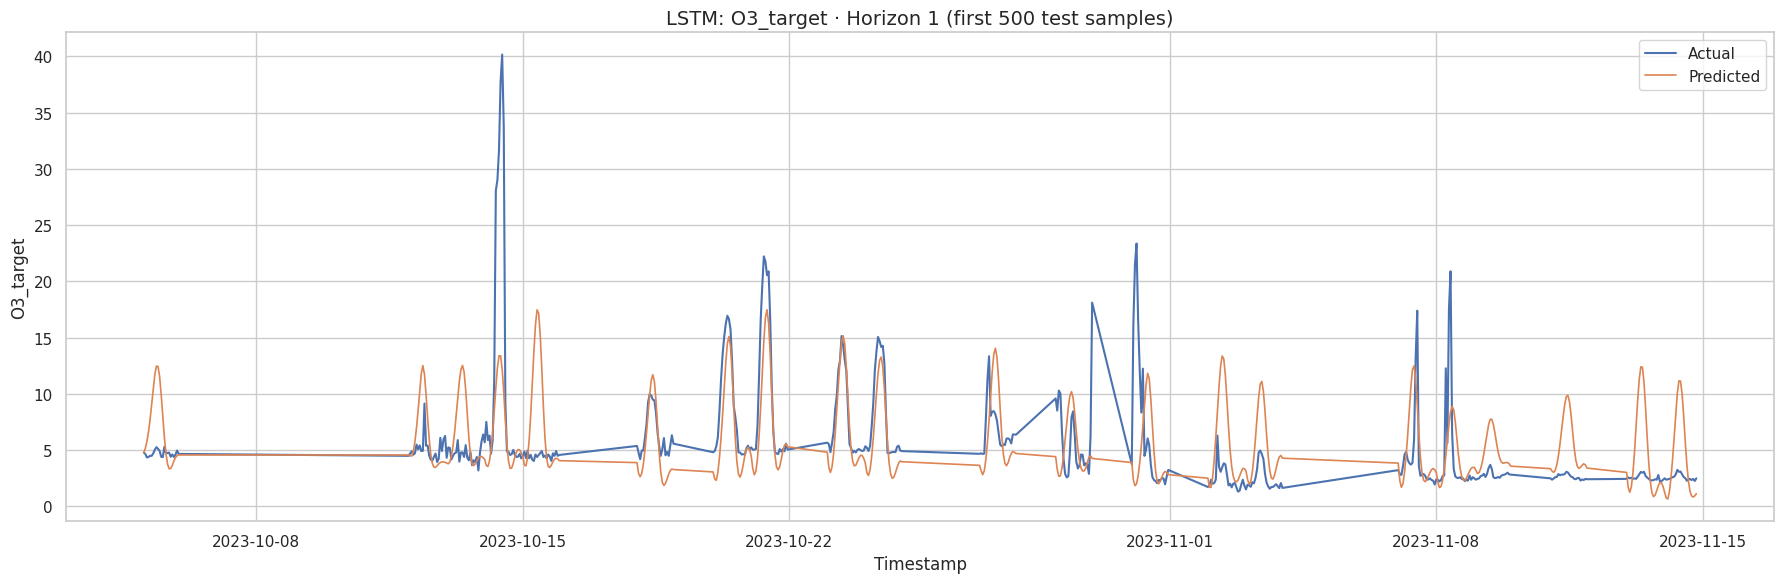

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch
from pathlib import Path

# --- Configuration: Set which site and target to plot ---
SITE_TO_PLOT = 'site_1'
TARGET_TO_PLOT = 'O3_target' # You can change this to 'NO2_target'

print(f"[INFO] Preparing a lightweight plot for {TARGET_TO_PLOT} at {SITE_TO_PLOT}...")

# --- Main Execution Block ---
try:
    # --- Load the data for the single site ---
    SITE_DF = load_site_dataframe(SITE_TO_PLOT)

    # --- Load the saved champion model checkpoint ---
    checkpoint_path = BASE_DIR / ARTIFACT_DIR / f"lstm_{TARGET_TO_PLOT}_champion.pt"
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    print(f"[INFO] Successfully loaded checkpoint: {checkpoint_path}")

    # --- Recreate model and load scalers from the checkpoint ---
    params = checkpoint['params']
    feature_cols_from_training = checkpoint['feature_cols']

    model = TemporalLSTM(
        input_size=len(feature_cols_from_training),
        hidden_size=params['hidden_size'],
        horizon=params['horizon'],
        target_dim=1,
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()

    feature_scaler = checkpoint['feature_scaler']
    target_scaler = checkpoint['target_scaler']

    # --- Prepare the test data for plotting ---
    # This feature engineering is now done only on the single-site DF
    lstm_base_df = add_rolling_features(SITE_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, [6, 24])
    base_feature_df, _ = build_feature_matrix(lstm_base_df)

    sequence_records = generate_sequences(base_feature_df, feature_cols_from_training, params['window'], params['horizon'])
    projected_sequences = project_sequences_to_target(sequence_records, TARGET_TO_PLOT)

    # We still need the timestamps from the original test split
    # To get this, we need the unscaled `test_seq`
    _, _, test_seq = split_sequences_lstm(projected_sequences)
    timestamps_h1 = [seq['target_ts'][0] for seq in test_seq]

    # Apply scaling to the test data for prediction
    test_scaled = apply_scalers(test_seq, feature_scaler, target_scaler)
    test_loader = DataLoader(SequenceDataset(test_scaled), batch_size=params['batch_size'])

    # --- Get Predictions and Actuals ---
    all_preds_scaled, all_targets_scaled = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            all_preds_scaled.append(model(xb.to(DEVICE)).cpu().numpy())
            all_targets_scaled.append(yb.numpy())

    pred_array = np.concatenate(all_preds_scaled)
    target_array = np.concatenate(all_targets_scaled)

    pred_restored = inverse_transform_predictions(pred_array, target_scaler)
    target_restored = inverse_transform_predictions(target_array, target_scaler)

    # --- Create DataFrame for Plotting ---
    plot_df = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps_h1),
        'Actual': target_restored[:, 0, 0], # Horizon 1, first target
        'Predicted': pred_restored[:, 0, 0],  # Horizon 1, first target
    })

    # --- Create the Plot ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(18, 6))

    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Actual', label='Actual', linewidth=1.5)
    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Predicted', label='Predicted', linewidth=1.2)

    plt.title(f'LSTM: {TARGET_TO_PLOT} · Horizon 1 (first 500 test samples)', fontsize=14)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel(TARGET_TO_PLOT, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure you have run all the setup cells that define the helper functions (like 'load_site_dataframe', 'TemporalLSTM', etc.) first.")

[INFO] Preparing a lightweight plot for NO2_target at site_1...
[INFO] Successfully loaded checkpoint: /content/PS2-SIH25/artifacts/final_models/lstm_NO2_target_champion.pt
[DEBUG] Generated 24984 sequences (window=48, horizon=48)


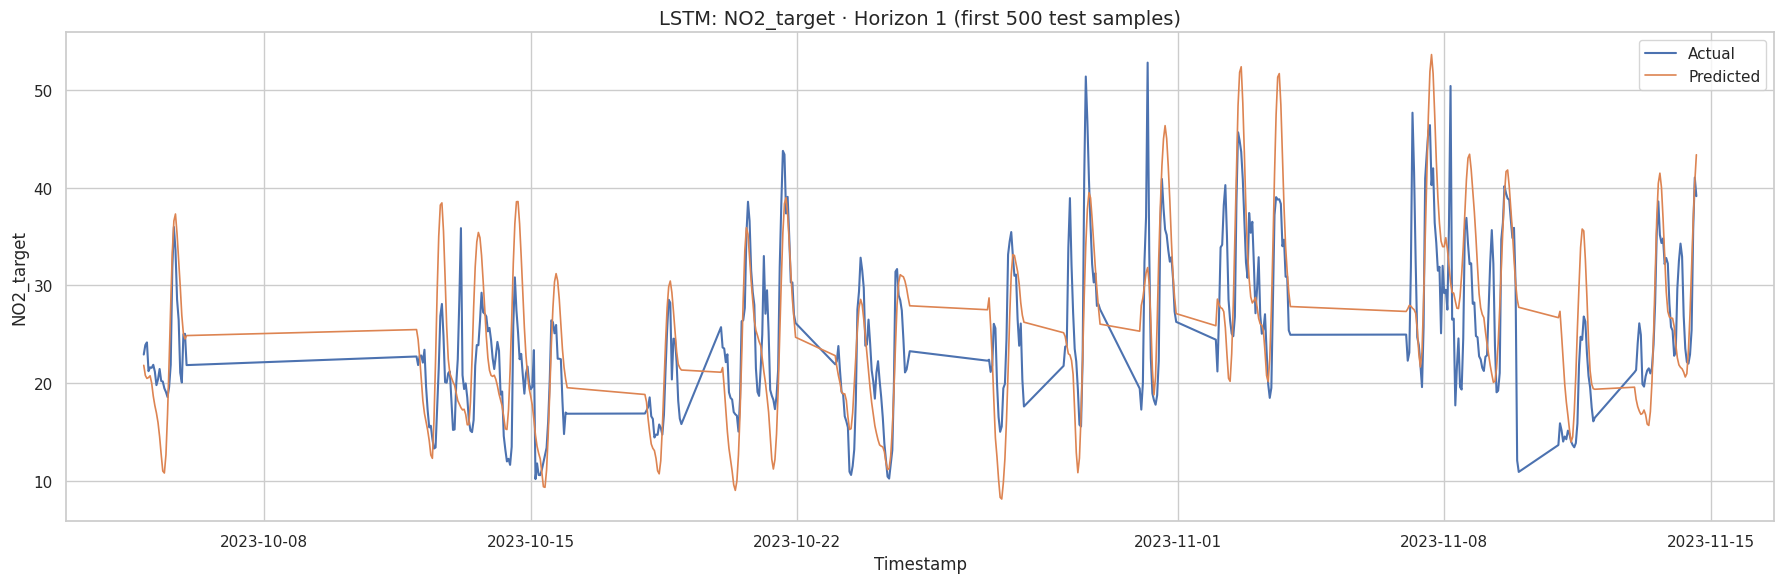

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch
from pathlib import Path

# --- Configuration: Set which site and target to plot ---
SITE_TO_PLOT = 'site_1'
TARGET_TO_PLOT = 'NO2_target' # <-- Changed to plot the NO2 model

print(f"[INFO] Preparing a lightweight plot for {TARGET_TO_PLOT} at {SITE_TO_PLOT}...")

# --- Main Execution Block ---
try:
    # --- Load the data for the single site ---
    SITE_DF = load_site_dataframe(SITE_TO_PLOT)

    # --- Load the saved champion model checkpoint ---
    checkpoint_path = BASE_DIR / ARTIFACT_DIR / f"lstm_{TARGET_TO_PLOT}_champion.pt"
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    print(f"[INFO] Successfully loaded checkpoint: {checkpoint_path}")

    # --- Recreate model and load scalers from the checkpoint ---
    params = checkpoint['params']
    feature_cols_from_training = checkpoint['feature_cols']

    model = TemporalLSTM(
        input_size=len(feature_cols_from_training),
        hidden_size=params['hidden_size'],
        horizon=params['horizon'],
        target_dim=1,
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    model.eval()

    feature_scaler = checkpoint['feature_scaler']
    target_scaler = checkpoint['target_scaler']

    # --- Prepare the test data for plotting ---
    lstm_base_df = add_rolling_features(SITE_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, [6, 24])
    base_feature_df, _ = build_feature_matrix(lstm_base_df)

    sequence_records = generate_sequences(base_feature_df, feature_cols_from_training, params['window'], params['horizon'])
    projected_sequences = project_sequences_to_target(sequence_records, TARGET_TO_PLOT)

    _, _, test_seq = split_sequences_lstm(projected_sequences)
    timestamps_h1 = [seq['target_ts'][0] for seq in test_seq]

    test_scaled = apply_scalers(test_seq, feature_scaler, target_scaler)
    test_loader = DataLoader(SequenceDataset(test_scaled), batch_size=params['batch_size'])

    # --- Get Predictions and Actuals ---
    all_preds_scaled, all_targets_scaled = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            all_preds_scaled.append(model(xb.to(DEVICE)).cpu().numpy())
            all_targets_scaled.append(yb.numpy())

    pred_array = np.concatenate(all_preds_scaled)
    target_array = np.concatenate(all_targets_scaled)

    pred_restored = inverse_transform_predictions(pred_array, target_scaler)
    target_restored = inverse_transform_predictions(target_array, target_scaler)

    # --- Create DataFrame for Plotting ---
    plot_df = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps_h1),
        'Actual': target_restored[:, 0, 0],
        'Predicted': pred_restored[:, 0, 0],
    })

    # --- Create the Plot ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(18, 6))

    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Actual', label='Actual', linewidth=1.5)
    sns.lineplot(data=plot_df.head(500), x='timestamp', y='Predicted', label='Predicted', linewidth=1.2)

    plt.title(f'LSTM: {TARGET_TO_PLOT} · Horizon 1 (first 500 test samples)', fontsize=14)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel(TARGET_TO_PLOT, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure you have run all the setup cells that define the helper functions (like 'load_site_dataframe', 'TemporalLSTM', etc.) first.")

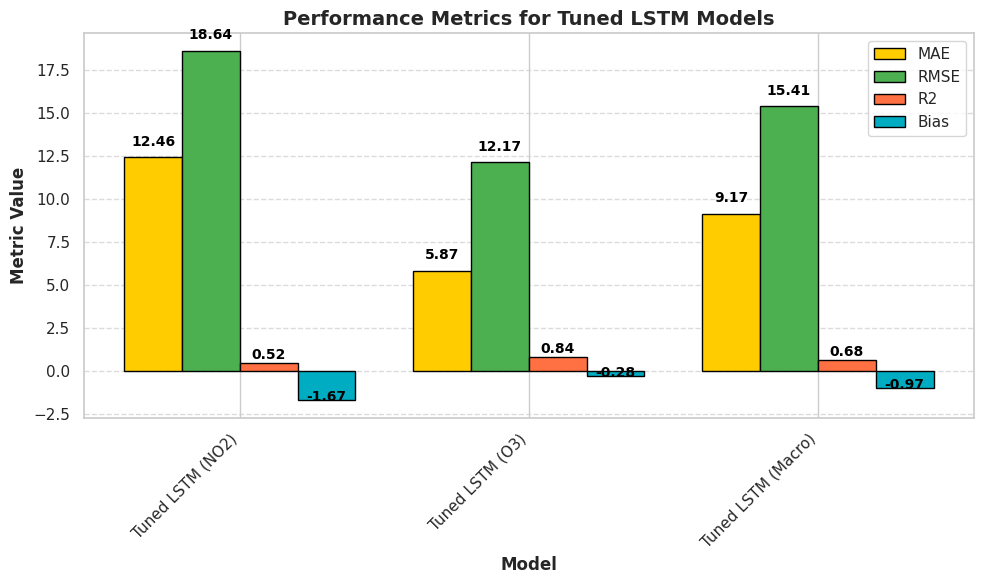

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Tuned LSTM (NO2)', 'Tuned LSTM (O3)', 'Tuned LSTM (Macro)']
mae = [12.461455, 5.869999, 9.165727]
rmse = [18.643829, 12.171157, 15.407493]
r2 = [0.520576, 0.843905, 0.682241]
bias = [-1.669980, -0.275013, -0.972497]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width and positions
bar_width = 0.2
index = np.arange(len(models))

# Create bars for each metric with improved colors and aesthetics
ax.bar(index - 1.5 * bar_width, mae, bar_width, label='MAE', color='#FFCC00', edgecolor='black')
ax.bar(index - 0.5 * bar_width, rmse, bar_width, label='RMSE', color='#4CAF50', edgecolor='black')
ax.bar(index + 0.5 * bar_width, r2, bar_width, label='R2', color='#FF7043', edgecolor='black')
ax.bar(index + 1.5 * bar_width, bias, bar_width, label='Bias', color='#00ACC1', edgecolor='black')

# Add the values above the bars
for i in range(len(models)):
    ax.text(index[i] - 1.5 * bar_width, mae[i] + 0.5, f'{mae[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    ax.text(index[i] - 0.5 * bar_width, rmse[i] + 0.5, f'{rmse[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    ax.text(index[i] + 0.5 * bar_width, r2[i] + 0.05, f'{r2[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    ax.text(index[i] + 1.5 * bar_width, bias[i] - 0.2, f'{bias[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Labels and title
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics for Tuned LSTM Models', fontsize=14, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=11)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
